## **F1L Notebook 1 of 3: Single-cell RNAseq Analysis**
This notebook follows the first part (1 of 3) of the FigureOne Lab Internship Emulator developed by Dean Lee. The code is modified from [Dean's repo](https://github.com/deanslee/FigureOneLab/tree/main/kinker). In this script, `UMICount_data.txt` from Pan-cancer cell line heterogeneity single-cell RNA-seq dataset (Kinker et al, 2020) is preprocessed into the `h5ad` format for a downstream analysis with `scanpy` to plot a UMAP plot.


### 1. Setting up a python environment
Google Colab comes with many pre-installed Python packages needed for this analysis. `anndata` and `scanpy` are two additional packages for single-cell RNA analysis.

In [1]:
# install additional packages
! pip install --quiet anndata scanpy

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 74.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 5.7 MB/s eta 0:00:00


In [26]:
# for UMAP
!pip install igraph --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/3.1 MB ? eta -:--:--
   ━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.3/3.1 MB 8.8 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━ 2.7/3.1 MB 40.3 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 32.0 MB/s eta 0:00:00


In [36]:
# foor Leiden clustering algorithm
!pip install leidenalg --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/2.0 MB ? eta -:--:--
   ━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.1/2.0 MB 4.0 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━ 1.2/2.0 MB 17.4 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 19.8 MB/s eta 0:00:00


In [23]:
import os
import numpy as np
import pandas as pd
import scipy
import anndata
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

In [27]:
import igraph

In [3]:
# set up warning for cleaner code
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

### 2. Downloading Kinker et al data directly into the Colab session.
In this exercise, the dataset from Kinker et al 2020 will be used and it is available for download at the Broad Institute Single-cell portal (SCP) website. Here, I wrote a script that automate this process in one-step using a curl download link.

In [4]:
# After signing into SCP, generate temporary curl download link with 'Bulk download
# The auth_code token can only be used once
!curl --insecure "https://singlecell.broadinstitute.org/single_cell/api/v1/bulk_download/generate_curl_config?accessions=SCP542&auth_code=H6QOxAsT&directory=all&context=study"  -o cfg.txt

# Search for Metadata.txt and UMIcount_data.txt
! mkdir data
! grep "Metadata.txt" cfg.txt | grep -oP 'url="[^"]+"' | sed 's/url="//;s/"$//' | \
  xargs -I {} wget --quiet -O data/Metadata.txt {} || echo "Download failed"

! grep "UMIcount_data.txt" cfg.txt | grep -oP 'url="[^"]+"' | sed 's/url="//;s/"$//' | \
  xargs -I {} wget --quiet -O data/UMIcount_data.txt {} || echo "Download failed"

# List the Data directory for confirmation
! ls -la data/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 16244    0 16244    0     0  13308      0 --:--:--  0:00:01 --:--:-- 13314
total 3402224
drwxr-xr-x 2 root root       4096 Jan 20 03:31 .
drwxr-xr-x 1 root root       4096 Jan 20 03:31 ..
-rw-r--r-- 1 root root    8901512 Aug 18  2022 Metadata.txt
-rw-r--r-- 1 root root 3474960024 Aug 18  2022 UMIcount_data.txt


### 3. Metadata
The metadata file contains general annotation for each cell in the dataset.

In [5]:
meta = pd.read_csv('/content/data/Metadata.txt', sep='\t')
meta.drop([0], axis=0, inplace=True) # drop the first row (specifying column dtypes)
meta.rename(columns={'NAME':'CellID', 'Cell_line':'CellLine', 'Pool_ID':'Pool', 'Cancer_type':'Indication'}, inplace=True)
print(meta.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53513 entries, 1 to 53513
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   CellID                           53513 non-null  object
 1   CellLine                         53513 non-null  object
 2   Pool                             53513 non-null  object
 3   Indication                       53513 non-null  object
 4   Genes_expressed                  53513 non-null  object
 5   Discrete_cluster_minpts5_eps1.8  10249 non-null  object
 6   Discrete_cluster_minpts5_eps1.5  11258 non-null  object
 7   Discrete_cluster_minpts5_eps1.2  14519 non-null  object
 8   CNA_subclone                     12799 non-null  object
 9   SkinPig_score                    53513 non-null  object
 10  EMTI_score                       53513 non-null  object
 11  EMTII_score                      53513 non-null  object
 12  EMTIII_score                    

<ipython-input-5-4e60043898f1>:1: DtypeWarning: Columns (4,9,10,11,12,13,14,15,16,17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  meta = pd.read_csv('/content/data/Metadata.txt', sep='\t')


In [12]:
# Overview of Metadata.txt
print(meta.iloc[:,0:5].head())
print("Number of cell lines: ", meta['CellLine'].nunique())
print("Number of cancer types: ", meta['Indication'].nunique())
print("Number of pools: ", meta['Pool'].nunique())

# Make sure that Genes_expressed is numeric
meta['Genes_expressed'] = pd.to_numeric(meta['Genes_expressed'], errors='coerce')
print(f"Average number of genes expressed: {meta['Genes_expressed'].mean()}")

                  CellID       CellLine Pool   Indication Genes_expressed
1  AAACCTGAGACATAAC-1-18  NCIH2126_LUNG   18  Lung Cancer            4318
2  AACGTTGTCACCCGAG-1-18  NCIH2126_LUNG   18  Lung Cancer            5200
3  AACTGGTAGACACGAC-1-18  NCIH2126_LUNG   18  Lung Cancer            4004
4  AACTGGTAGGGCTTGA-1-18  NCIH2126_LUNG   18  Lung Cancer            4295
5  AACTGGTAGTACTTGC-1-18  NCIH2126_LUNG   18  Lung Cancer            4842
Number of cell lines:  198
Number of cancer types:  22
Number of pools:  9
Average number of genes expressed: 3752.829518061032


### 4. UMI Count Data
Individual transcripts are barcoded with unique molecular identifiers (UMIs) before cDNA amplification, resulting in a more accurate quantification of the transcript count.

In [13]:
# preview UMIcount_data.txt
# the first three rows are CellID, CellLine, and Pool
# only need the first row, CellID
pd.read_csv('/content/data/UMIcount_data.txt', nrows=5,
            usecols=range(5), sep='\t', header=None)

,0,1,2,3,4
0,NaN,AAACCTGAGACATAAC-1-18,AAACCTGCACAACGCC-1-18,AAACCTGCAGACAAGC-1-18,AAACCTGCAGCTCGAC-1-18
1,Cell_line,NCIH2126_LUNG,SW579_THYROID,C32_SKIN,SW579_THYROID
2,Pool_ID,18,18,18,18
3,A1BG,0,1,1,1
4,A1BG-AS1,0,0,0,0


In [14]:
# Get cell ID as rows
# First row is cell id, Second row is Cell line, Third row is Pool ID
counts_cellid = pd.read_csv('/content/data/UMIcount_data.txt', nrows=1, sep='\t', header=None)
counts_cellid = counts_cellid.transpose()
counts_cellid.drop([0], inplace=True)
counts_cellid

,0
1,AAACCTGAGACATAAC-1-18
2,AAACCTGCACAACGCC-1-18
3,AAACCTGCAGACAAGC-1-18
4,AAACCTGCAGCTCGAC-1-18
5,AAACCTGCATGGATGG-1-18
...,...
56978,c4788
56979,c4789
56980,c4793
56981,c4800


#### Read in the entire `UMIcount_data.txt` into memory
To read in this entire dataset (3.47 GB), you need to make sure that you have enough RAM (needs to use V28 compute on Colab to support this operation because you need ~ 42 GB RAM)

In [15]:
%%time
counts = pd.read_csv('/content/data/UMIcount_data.txt', sep='\t', skiprows=3, header=None, index_col=0)
counts = counts.transpose()
counts

CPU times: user 11min 55s, sys: 34.6 s, total: 12min 29s
Wall time: 12min 23s


,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A2ML1-AS2,A3GALT2,A4GALT,...,PRICKLE4,RABL6,RAET1E-AS1,RGS5,SERPINA3,SPATA13,TBC1D26,TIMM10B,TMBIM4,TMEM256-PLSCR3
1,0,0,0,0,0,0,0,0,0,0,...,0,6,0,0,0,0,0,1,0,0
2,1,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,1,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56978,1,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,4,4,0
56979,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
56980,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
56981,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [16]:
# Assign counts index with counts_cellid
# Filter for cells that have meta data info
counts.index = counts_cellid[0]
counts.index.name = None
a = counts.index.isin(meta['CellID'])
counts = counts[a]
counts

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A2ML1-AS2,A3GALT2,A4GALT,...,PRICKLE4,RABL6,RAET1E-AS1,RGS5,SERPINA3,SPATA13,TBC1D26,TIMM10B,TMBIM4,TMEM256-PLSCR3
AAACCTGAGACATAAC-1-18,0,0,0,0,0,0,0,0,0,0,...,0,6,0,0,0,0,0,1,0,0
AAACCTGCACAACGCC-1-18,1,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
AAACCTGCAGACAAGC-1-18,1,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,1,0,0,0,0
AAACCTGCAGCTCGAC-1-18,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACCTGCATGGATGG-1-18,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c4788,1,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,4,4,0
c4789,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
c4793,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
c4800,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [17]:
# Check to make sure all cells in counts are in meta
# Assign and reindex meta. Reindex arrange df such that rows are in the order of reindex
# If the LHS df doesn't have the RHS index. It'll produce NA
meta = meta.set_index('CellID')
meta = meta.reindex(index=counts.index)

# Check if counts equal meta
counts.index.equals(meta.index)

True

### 5. Convert count data into `h5ad` with `AnnData` for scanpy

In [18]:
adata = anndata.AnnData(X=scipy.sparse.csr_matrix(counts),
                        obs=meta,
                        var=counts.columns.to_frame())
del counts
adata.var.drop(columns=[0], inplace=True)
adata.var.index.name = None
adata

AnnData object with n_obs × n_vars = 53513 × 30314
    obs: 'CellLine', 'Pool', 'Indication', 'Genes_expressed', 'Discrete_cluster_minpts5_eps1.8', 'Discrete_cluster_minpts5_eps1.5', 'Discrete_cluster_minpts5_eps1.2', 'CNA_subclone', 'SkinPig_score', 'EMTI_score', 'EMTII_score', 'EMTIII_score', 'IFNResp_score', 'p53Sen_score', 'EpiSen_score', 'StressResp_score', 'ProtMatu_score', 'ProtDegra_score', 'G1/S_score', 'G2/M_score'

In [19]:
# Make sure dtypes for metadata is correct
adata.obs['CellLine'] = adata.obs['CellLine'].astype(str)
adata.obs['Pool'] = adata.obs['Pool'].astype(str)
adata.obs['Indication'] = adata.obs['Indication'].astype(str)
adata.obs['Genes_expressed'] = adata.obs['Genes_expressed'].astype(int)
adata.obs['Discrete_cluster_minpts5_eps1.8'] = adata.obs['Discrete_cluster_minpts5_eps1.8'].astype(str)
adata.obs['Discrete_cluster_minpts5_eps1.5'] = adata.obs['Discrete_cluster_minpts5_eps1.5'].astype(str)
adata.obs['Discrete_cluster_minpts5_eps1.2'] = adata.obs['Discrete_cluster_minpts5_eps1.2'].astype(str)
adata.obs['CNA_subclone'] = adata.obs['CNA_subclone'].astype(str)
adata.obs['SkinPig_score'] = adata.obs['SkinPig_score'].astype(float)
adata.obs['EMTI_score'] = adata.obs['EMTI_score'].astype(float)
adata.obs['EMTII_score'] = adata.obs['EMTII_score'].astype(float)
adata.obs['EMTIII_score'] = adata.obs['EMTIII_score'].astype(float)
adata.obs['IFNResp_score'] = adata.obs['IFNResp_score'].astype(float)
adata.obs['p53Sen_score'] = adata.obs['p53Sen_score'].astype(float)
adata.obs['EpiSen_score'] = adata.obs['EpiSen_score'].astype(float)
adata.obs['StressResp_score'] = adata.obs['StressResp_score'].astype(float)
adata.obs['ProtMatu_score'] = adata.obs['ProtMatu_score'].astype(float)
adata.obs['ProtDegra_score'] = adata.obs['ProtDegra_score'].astype(float)
adata.obs['G1/S_score'] = adata.obs['G1/S_score'].astype(float)
adata.obs['G2/M_score'] = adata.obs['G2/M_score'].astype(float)

#### Apply filters
* Keep genes that have at least `min_cells=10` cells.
* Keep cells that express at least `min_genes=200` genes.

In [20]:
sc.pp.filter_genes(adata, min_cells=10)
sc.pp.filter_cells(adata, min_genes=200)
adata

AnnData object with n_obs × n_vars = 53513 × 23081
    obs: 'CellLine', 'Pool', 'Indication', 'Genes_expressed', 'Discrete_cluster_minpts5_eps1.8', 'Discrete_cluster_minpts5_eps1.5', 'Discrete_cluster_minpts5_eps1.2', 'CNA_subclone', 'SkinPig_score', 'EMTI_score', 'EMTII_score', 'EMTIII_score', 'IFNResp_score', 'p53Sen_score', 'EpiSen_score', 'StressResp_score', 'ProtMatu_score', 'ProtDegra_score', 'G1/S_score', 'G2/M_score', 'n_genes'
    var: 'n_cells'

In [21]:
!mkdir outs
adata.write('/content/outs/240701_kinker_anndata.h5ad')

In [22]:
!ls -la outs/

total 2367492
drwxr-xr-x 2 root root       4096 Jan 20 03:55 ./
drwxr-xr-x 1 root root       4096 Jan 20 03:55 ../
-rw-r--r-- 1 root root 2424298682 Jan 20 03:55 240701_kinker_anndata.h5ad


### 5. Use `scanpy` to explore patterns in the scRNA-seq dataset by cell types.
Here, I will perform one preprocessing step at a time. Because some steps are memory intensive, troubleshoooting will be easier step-by-step based on this function.

```
def BasicScanpyPreprocessing(adata, n_top_genes=2000, n_neighbors=10, n_pcs=40, random_state=20):
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes, flavor='seurat')
    #sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs, random_state=random_state)
    sc.tl.umap(adata, random_state=random_state)
    sc.tl.leiden(adata, random_state=random_state)
    return adata
```

In [28]:
adata = sc.read_h5ad('/content/outs/240701_kinker_anndata.h5ad')

In [29]:
# Total-count normalize (library-size correct)
sc.pp.normalize_total(adata, target_sum=1e4)

In [30]:
# Logarithmize the data:
sc.pp.log1p(adata)

In [31]:
# Identify highly-variable genes.
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor='seurat')

In [32]:
# Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.
sc.tl.pca(adata, svd_solver='arpack')

In [33]:
# Computing the neighborhood graph
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40, random_state=40)

In [34]:
# Embedding the neighborhood graph in 2D using UMAP
sc.tl.umap(adata, random_state=40)

In [37]:
# Leiden clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.
sc.tl.leiden(adata, random_state=40)

In [38]:
# write out results
adata.write('/content/outs/240702_kinker_anndata_umap.h5ad')

### 6. Plots

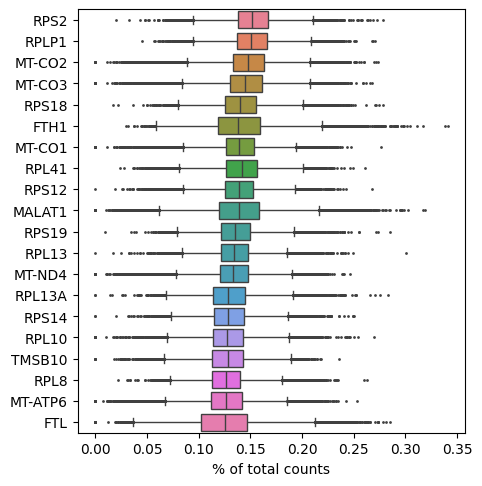

In [39]:
# Highly expressed genes
sc.pl.highest_expr_genes(adata, n_top=20)

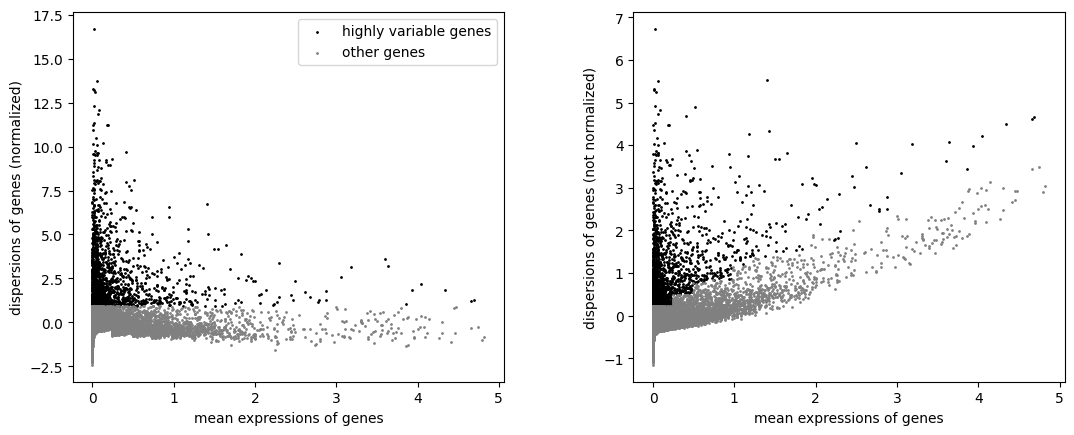

In [40]:
# Highly variable genes
sc.pl.highly_variable_genes(adata)

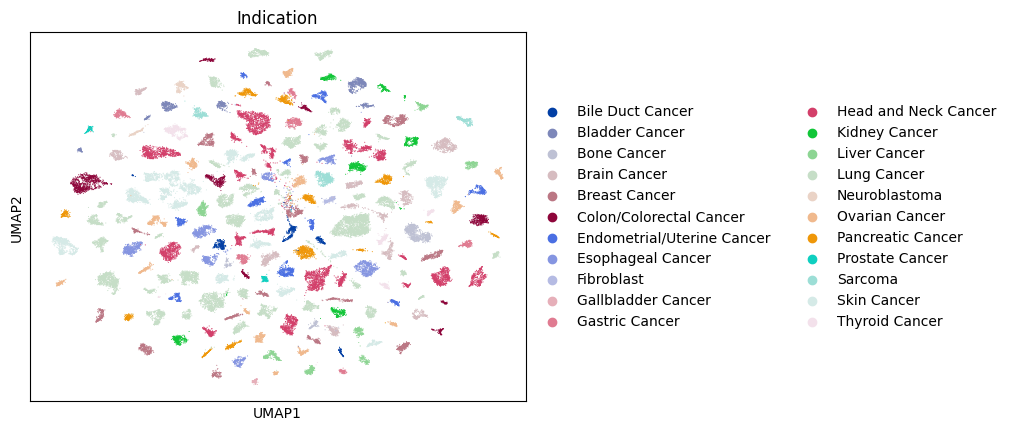

In [41]:
# UMAP
sc.pl.umap(adata, color=['Indication'])

This UMAP doesn't look like Figure 1B. Figure 1B shows t-SNE. t-SNE and UMAP are both non-linear dimensional reduction techniques but they do produce different results.

In [42]:
adata

AnnData object with n_obs × n_vars = 53513 × 23081
    obs: 'CellLine', 'Pool', 'Indication', 'Genes_expressed', 'Discrete_cluster_minpts5_eps1.8', 'Discrete_cluster_minpts5_eps1.5', 'Discrete_cluster_minpts5_eps1.2', 'CNA_subclone', 'SkinPig_score', 'EMTI_score', 'EMTII_score', 'EMTIII_score', 'IFNResp_score', 'p53Sen_score', 'EpiSen_score', 'StressResp_score', 'ProtMatu_score', 'ProtDegra_score', 'G1/S_score', 'G2/M_score', 'n_genes', 'leiden'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'Indication_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [43]:
!ls -la outs/

total 4766316
drwxr-xr-x 2 root root       4096 Jan 20 04:38 .
drwxr-xr-x 1 root root       4096 Jan 20 03:55 ..
-rw-r--r-- 1 root root 2424298682 Jan 20 03:55 240701_kinker_anndata.h5ad
-rw-r--r-- 1 root root 2456387793 Jan 20 04:38 240702_kinker_anndata_umap.h5ad
